In [1]:
dataset = "cifar10"
algorithm = "bcp"

### 1. Load Dataset

In [2]:
from art.utils import load_cifar10
import numpy as np

(_x1, _y1), (_x2, _y2), _min, _max = load_cifar10()
x = np.concatenate((_x1, _x2))
y = np.concatenate((_y1, _y2))

# Swap axes to PyTorch's NCHW format
x = np.transpose(x, (0, 3, 1, 2)).astype(np.float32)

target_train_size = 2500
target_test_size = 2500
x_target_train = x[:target_train_size]
y_target_train = y[:target_train_size]
x_target_test = x[target_train_size:target_train_size+target_test_size]
y_target_test = y[target_train_size:target_train_size+target_test_size]

### 2. Define Target Model

In [3]:
from torch import nn
from torchsummary import summary
import math

def cifar_model(): 
    model = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*8*8,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            m.bias.data.zero_()
    return model

summary(cifar_model(), input_size=x_target_train[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
              ReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
              ReLU-4             [-1, 32, 8, 8]               0
           Flatten-5                 [-1, 2048]               0
            Linear-6                  [-1, 100]         204,900
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 214,918
Trainable params: 214,918
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.82
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


### 3. Train Target Model

In [4]:
! cd bcp && python train_cifar10.py --model cifar_model --prefix 2500 --epoch 100 --batch_size 64 --rampup 10 --no_augmentation

2022-04-09 16:51:05.487194
Namespace(alpha=0.03529411764705882, augmentation=False, batch_size=64, bce=False, cuda_ids=None, data='cifar10', drop_last=False, epochs=100, epsilon=0.1411764705882353, epsilon_infty=0.03137254901960784, epsilon_pgd=0.1411764705882353, epsilon_train=0.1411764705882353, epsilon_train_infty=0.03137254901960784, gamma=0.5, kappa=0.0, kappa_schedule_length=10, linfty=False, lr=0.001, lr_scheduler='step', method='BCP', model='cifar_model', model_factor=8, momentum=0.9, niter=100, no_augmentation=True, no_save=False, no_shuffle=False, normalization=False, opt='adam', opt_iter=1, pgd=False, prefix='models/cifar10/2500_cifar_model_BCP_data_cifar10_epochs_100_epsilon_train_0.1411764705882353_lr_0.001_opt_adam_opt_iter_1_rampup_10_sniter_1_starting_kappa_1.0_train_method_BCP_warmup_10', print=False, rampup=10, real_time=False, resnet_N=1, resnet_factor=1, save=True, schedule_length=10, seed=2019, shuffle=True, sniter=1, starting_epsilon=0.0, starting_kappa=1.0, step_


Taken 5.97407603263855 s/epoch
Test: [1/40]	Time 2.633 (2.633)	L 1.6582 (1.6582)//RL 2.231 (2.231)//RL1 2.415 (2.415)	E 0.609 (0.609)//RE 0.812 (0.812)//RE1 0.844 (0.844)
Test: [40/40]	Time 0.016 (0.158)	L 1.6180 (1.6112)//RL 2.128 (2.153)//RL1 2.305 (2.337)	E 0.750 (0.566)//RE 0.750 (0.750)//RE1 0.750 (0.796)

 * Robust error 0.750	Error 0.566
12 th epoch: epsilon: 0.0313725 - 0.0470588, kappa: 0.7778 - 0.6667, lr: 0.0010000
Epoch: [12][1/40]	Time 2.484 (2.484)	Eps 0.031	Data 2.376 (2.376)	L 1.2104 (1.2104)//RL 1.7077 (1.7077)//RL1 1.8786 (1.8786)	E 0.422 (0.422)//RE 0.672 (0.672)//RE1 0.719 (0.719)
Epoch: [12][40/40]	Time 0.027 (0.157)	Eps 0.045	Data 0.001 (0.061)	L 0.9522 (1.2529)//RL 1.4101 (1.7651)//RL1 1.6006 (1.9434)	E 0.250 (0.438)//RE 0.500 (0.656)//RE1 0.750 (0.716)

Taken 6.603009223937988 s/epoch
Test: [1/40]	Time 3.071 (3.071)	L 1.6329 (1.6329)//RL 2.295 (2.295)//RL1 2.528 (2.528)	E 0.609 (0.609)//RE 0.844 (0.844)//RE1 0.875 (0.875)
Test: [40/40]	Time 0.024 (0.166)	L 1.60


 * Robust error 0.812	Error 0.620
LR DECAY STEP
Best Error Found! 0.812
22 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0010000
Epoch: [22][1/40]	Time 2.284 (2.284)	Eps 0.141	Data 2.165 (2.165)	L 1.4982 (1.4982)//RL 2.0679 (2.0679)//RL1 2.3525 (2.3525)	E 0.469 (0.469)//RE 0.750 (0.750)//RE1 0.859 (0.859)
Epoch: [22][40/40]	Time 0.024 (0.152)	Eps 0.155	Data 0.001 (0.056)	L 1.4922 (1.3080)//RL 1.9254 (1.7601)//RL1 2.1526 (1.9862)	E 0.500 (0.430)//RE 0.750 (0.652)//RE1 0.750 (0.752)

Taken 6.463472127914429 s/epoch
Test: [1/40]	Time 2.503 (2.503)	L 1.6709 (1.6709)//RL 2.242 (2.242)//RL1 2.529 (2.529)	E 0.625 (0.625)//RE 0.766 (0.766)//RE1 0.875 (0.875)
Test: [40/40]	Time 0.026 (0.166)	L 1.7134 (1.6117)//RL 2.260 (2.161)//RL1 2.550 (2.441)	E 0.500 (0.577)//RE 0.750 (0.762)//RE1 1.000 (0.844)

 * Robust error 0.762	Error 0.577
LR DECAY STEP
Best Error Found! 0.762
23 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0010000
Epoch: [23][1/40]

Epoch: [32][1/40]	Time 3.501 (3.501)	Eps 0.141	Data 3.317 (3.317)	L 1.1279 (1.1279)//RL 1.4723 (1.4723)//RL1 1.6416 (1.6416)	E 0.406 (0.406)//RE 0.516 (0.516)//RE1 0.547 (0.547)
Epoch: [32][40/40]	Time 0.029 (0.204)	Eps 0.155	Data 0.001 (0.084)	L 1.3274 (1.1813)//RL 1.6943 (1.5354)//RL1 1.8559 (1.6927)	E 0.500 (0.391)//RE 0.750 (0.555)//RE1 0.750 (0.630)

Taken 8.581037998199463 s/epoch
Test: [1/40]	Time 8.273 (8.273)	L 1.5748 (1.5748)//RL 1.989 (1.989)//RL1 2.177 (2.177)	E 0.609 (0.609)//RE 0.656 (0.656)//RE1 0.750 (0.750)
Test: [40/40]	Time 0.027 (0.325)	L 1.4989 (1.6135)//RL 1.859 (2.034)//RL1 2.049 (2.223)	E 0.750 (0.565)//RE 0.750 (0.722)//RE1 0.750 (0.784)

 * Robust error 0.722	Error 0.565
LR DECAY STEP
Best Error Found! 0.722
33 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0005000
Epoch: [33][1/40]	Time 2.958 (2.958)	Eps 0.141	Data 2.806 (2.806)	L 1.1893 (1.1893)//RL 1.5410 (1.5410)//RL1 1.7126 (1.7126)	E 0.453 (0.453)//RE 0.562 (0.562)//RE1 0.625 (0.

Epoch: [42][40/40]	Time 0.032 (0.187)	Eps 0.155	Data 0.002 (0.057)	L 1.1304 (1.0413)//RL 1.5586 (1.4061)//RL1 1.7750 (1.5824)	E 0.250 (0.343)//RE 0.750 (0.511)//RE1 1.000 (0.590)

Taken 7.818266868591309 s/epoch
Test: [1/40]	Time 3.027 (3.027)	L 1.6979 (1.6979)//RL 2.156 (2.156)//RL1 2.362 (2.362)	E 0.562 (0.562)//RE 0.734 (0.734)//RE1 0.766 (0.766)
Test: [40/40]	Time 0.018 (0.180)	L 1.6893 (1.5783)//RL 2.142 (2.034)//RL1 2.338 (2.239)	E 0.500 (0.570)//RE 0.750 (0.711)//RE1 0.750 (0.768)

 * Robust error 0.711	Error 0.570
LR DECAY STEP
43 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0002500
Epoch: [43][1/40]	Time 2.309 (2.309)	Eps 0.141	Data 2.200 (2.200)	L 0.9865 (0.9865)//RL 1.3398 (1.3398)//RL1 1.5155 (1.5155)	E 0.328 (0.328)//RE 0.469 (0.469)//RE1 0.531 (0.531)
Epoch: [43][40/40]	Time 0.027 (0.153)	Eps 0.155	Data 0.002 (0.056)	L 1.1346 (1.0477)//RL 1.5457 (1.4096)//RL1 1.7073 (1.5870)	E 0.500 (0.340)//RE 0.500 (0.508)//RE1 0.500 (0.594)

Taken 6.445133924


Taken 6.1603240966796875 s/epoch
Test: [1/40]	Time 7.178 (7.178)	L 1.5825 (1.5825)//RL 2.041 (2.041)//RL1 2.267 (2.267)	E 0.609 (0.609)//RE 0.688 (0.688)//RE1 0.766 (0.766)
Test: [40/40]	Time 0.017 (0.267)	L 1.3710 (1.5497)//RL 1.796 (2.004)//RL1 2.000 (2.227)	E 0.750 (0.555)//RE 0.750 (0.698)//RE1 0.750 (0.765)

 * Robust error 0.698	Error 0.555
LR DECAY STEP
Best Error Found! 0.698
53 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0001250
Epoch: [53][1/40]	Time 2.350 (2.350)	Eps 0.141	Data 2.228 (2.228)	L 0.8494 (0.8494)//RL 1.2205 (1.2205)//RL1 1.4103 (1.4103)	E 0.266 (0.266)//RE 0.391 (0.391)//RE1 0.516 (0.516)
Epoch: [53][40/40]	Time 0.024 (0.174)	Eps 0.155	Data 0.002 (0.057)	L 0.7753 (0.9581)//RL 1.0962 (1.3207)//RL1 1.2498 (1.5086)	E 0.000 (0.306)//RE 0.500 (0.473)//RE1 0.500 (0.566)

Taken 7.278604030609131 s/epoch
Test: [1/40]	Time 3.402 (3.402)	L 1.5655 (1.5655)//RL 2.021 (2.021)//RL1 2.245 (2.245)	E 0.578 (0.578)//RE 0.656 (0.656)//RE1 0.750 (0.750)

Test: [40/40]	Time 0.016 (0.277)	L 1.4270 (1.5412)//RL 1.842 (1.992)//RL1 2.042 (2.213)	E 0.750 (0.551)//RE 0.750 (0.694)//RE1 0.750 (0.754)

 * Robust error 0.694	Error 0.551
LR DECAY STEP
63 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0000625
Epoch: [63][1/40]	Time 2.329 (2.329)	Eps 0.141	Data 2.217 (2.217)	L 0.7598 (0.7598)//RL 1.0827 (1.0827)//RL1 1.2524 (1.2524)	E 0.172 (0.172)//RE 0.359 (0.359)//RE1 0.453 (0.453)
Epoch: [63][40/40]	Time 0.028 (0.159)	Eps 0.155	Data 0.002 (0.057)	L 0.3473 (0.9238)//RL 0.5810 (1.2793)//RL1 0.7294 (1.4677)	E 0.000 (0.290)//RE 0.000 (0.451)//RE1 0.000 (0.548)

Taken 6.6733717918396 s/epoch
Test: [1/40]	Time 3.221 (3.221)	L 1.6227 (1.6227)//RL 2.081 (2.081)//RL1 2.307 (2.307)	E 0.594 (0.594)//RE 0.719 (0.719)//RE1 0.750 (0.750)
Test: [40/40]	Time 0.012 (0.167)	L 1.4089 (1.5428)//RL 1.823 (1.993)//RL1 2.020 (2.215)	E 0.750 (0.553)//RE 0.750 (0.697)//RE1 0.750 (0.755)

 * Robust error 0.697	Error 0.553
LR DECAY STEP
64 th epo


 * Robust error 0.690	Error 0.556
LR DECAY STEP
73 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0000313
Epoch: [73][1/40]	Time 2.222 (2.222)	Eps 0.141	Data 2.117 (2.117)	L 1.1103 (1.1103)//RL 1.5103 (1.5103)//RL1 1.7222 (1.7222)	E 0.391 (0.391)//RE 0.625 (0.625)//RE1 0.672 (0.672)
Epoch: [73][40/40]	Time 0.025 (0.152)	Eps 0.155	Data 0.002 (0.055)	L 0.6870 (0.9005)//RL 0.9422 (1.2602)//RL1 1.0814 (1.4542)	E 0.250 (0.281)//RE 0.250 (0.445)//RE1 0.250 (0.546)

Taken 6.373129844665527 s/epoch
Test: [1/40]	Time 3.620 (3.620)	L 1.6179 (1.6179)//RL 2.076 (2.076)//RL1 2.305 (2.305)	E 0.594 (0.594)//RE 0.703 (0.703)//RE1 0.750 (0.750)
Test: [40/40]	Time 0.015 (0.173)	L 1.4038 (1.5428)//RL 1.829 (1.993)//RL1 2.029 (2.217)	E 0.750 (0.558)//RE 0.750 (0.688)//RE1 0.750 (0.756)

 * Robust error 0.688	Error 0.558
LR DECAY STEP
Best Error Found! 0.688
74 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0000313
Epoch: [74][1/40]	Time 2.172 (2.172)	Eps 

Epoch: [83][1/40]	Time 2.073 (2.073)	Eps 0.141	Data 1.945 (1.945)	L 0.9023 (0.9023)//RL 1.2475 (1.2475)//RL1 1.4286 (1.4286)	E 0.250 (0.250)//RE 0.453 (0.453)//RE1 0.594 (0.594)
Epoch: [83][40/40]	Time 0.024 (0.156)	Eps 0.155	Data 0.002 (0.050)	L 1.1246 (0.8901)//RL 1.4797 (1.2477)//RL1 1.7322 (1.4421)	E 0.500 (0.277)//RE 0.750 (0.441)//RE1 0.750 (0.540)

Taken 6.492685794830322 s/epoch
Test: [1/40]	Time 3.220 (3.220)	L 1.6047 (1.6047)//RL 2.058 (2.058)//RL1 2.287 (2.287)	E 0.594 (0.594)//RE 0.688 (0.688)//RE1 0.734 (0.734)
Test: [40/40]	Time 0.012 (0.148)	L 1.4058 (1.5470)//RL 1.826 (1.996)//RL1 2.023 (2.221)	E 0.750 (0.555)//RE 0.750 (0.689)//RE1 0.750 (0.751)

 * Robust error 0.689	Error 0.555
LR DECAY STEP
84 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0000156
Epoch: [84][1/40]	Time 2.068 (2.068)	Eps 0.141	Data 1.938 (1.938)	L 0.8217 (0.8217)//RL 1.1434 (1.1434)//RL1 1.3236 (1.3236)	E 0.266 (0.266)//RE 0.375 (0.375)//RE1 0.438 (0.438)
Epoch: [84][40/40]	

Epoch: [93][40/40]	Time 0.028 (0.162)	Eps 0.155	Data 0.003 (0.053)	L 1.1513 (0.8849)//RL 1.5848 (1.2418)//RL1 1.8219 (1.4363)	E 0.250 (0.276)//RE 0.500 (0.433)//RE1 0.750 (0.542)

Taken 7.667202949523926 s/epoch
Test: [1/40]	Time 5.953 (5.953)	L 1.6107 (1.6107)//RL 2.065 (2.065)//RL1 2.295 (2.295)	E 0.594 (0.594)//RE 0.703 (0.703)//RE1 0.750 (0.750)
Test: [40/40]	Time 0.011 (0.229)	L 1.4056 (1.5468)//RL 1.826 (1.996)//RL1 2.023 (2.221)	E 0.750 (0.554)//RE 0.750 (0.690)//RE1 0.750 (0.750)

 * Robust error 0.690	Error 0.554
LR DECAY STEP
94 th epoch: epsilon: 0.1411765 - 0.1411765, kappa: 0.0000 - 0.0000, lr: 0.0000078
Epoch: [94][1/40]	Time 2.742 (2.742)	Eps 0.141	Data 2.571 (2.571)	L 0.7839 (0.7839)//RL 1.0977 (1.0977)//RL1 1.2818 (1.2818)	E 0.250 (0.250)//RE 0.406 (0.406)//RE1 0.516 (0.516)
Epoch: [94][40/40]	Time 0.021 (0.162)	Eps 0.155	Data 0.001 (0.065)	L 0.2427 (0.8846)//RL 0.4235 (1.2419)//RL1 0.5258 (1.4368)	E 0.000 (0.275)//RE 0.000 (0.434)//RE1 0.000 (0.537)

Taken 6.838275909

iter 1 / out ratio: 0.53781247 -> 0.00165625 / t_BCP/t_LMT: 0.7191
iter 2 / out ratio: 0.00165625 -> 0.00000781 / t_BCP/t_LMT: 0.9999
iter 3 / out ratio: 0.00000781 -> 0.00000000 / t_BCP/t_LMT: 1.0000
iter 1 / out ratio: 0.53475314 -> 0.00163281 / t_BCP/t_LMT: 0.7236
iter 2 / out ratio: 0.00163281 -> 0.00000625 / t_BCP/t_LMT: 0.9999
iter 3 / out ratio: 0.00000625 -> 0.00000000 / t_BCP/t_LMT: 1.0000
iter 1 / out ratio: 0.54593909 -> 0.00203906 / t_BCP/t_LMT: 0.7097
iter 2 / out ratio: 0.00203906 -> 0.00000781 / t_BCP/t_LMT: 0.9998
iter 3 / out ratio: 0.00000781 -> 0.00000000 / t_BCP/t_LMT: 1.0000
iter 1 / out ratio: 0.54234689 -> 0.00178125 / t_BCP/t_LMT: 0.7133
iter 2 / out ratio: 0.00178125 -> 0.00000938 / t_BCP/t_LMT: 0.9998
iter 3 / out ratio: 0.00000938 -> 0.00000000 / t_BCP/t_LMT: 1.0000
iter 1 / out ratio: 0.53760469 -> 0.00147344 / t_BCP/t_LMT: 0.7189
iter 2 / out ratio: 0.00147344 -> 0.00000938 / t_BCP/t_LMT: 0.9998
iter 3 / out ratio: 0.00000938 -> 0.00000000 / t_BCP/t_LMT: 1.

In [11]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

def get_acc(model, x, y):
    _, predictions = torch.max(model(torch.from_numpy(x)), 1)
    acc = np.mean(predictions.detach().numpy() == np.argmax(y, axis=1))
    return acc

model = cifar_model()
model.load_state_dict(torch.load("models/cifar10_bcp.pth", map_location=torch.device('cpu'))['state_dict'][0])
model.eval()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print("Train accuracy:", get_acc(model, x_target_train, y_target_train))
print("Test accuracy:", get_acc(model, x_target_test, y_target_test))

Train accuracy: 0.728
Test accuracy: 0.4464


### 4. Generate Adversarial Examples using HopSkipJump

In [12]:
from art.attacks.evasion import HopSkipJump
from art.estimators.classification.pytorch import PyTorchClassifier
from numpy.random import choice

art_classifier=PyTorchClassifier(
    model=model,
    clip_values=(_min, _max),
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)
attack = HopSkipJump(classifier=art_classifier, norm=2, targeted=False)

train_idx = choice(len(x_target_train), 100)
y_adv_train = y_target_train[train_idx]
x_adv_train = attack.generate(x=x_target_train[train_idx], y=y_adv_train)

test_idx = choice(len(x_target_test), 100)
y_adv_test = y_target_test[test_idx]
x_adv_test = attack.generate(x=x_target_test[test_idx], y=y_adv_test)

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/100 [00:00<?, ?it/s]

### 5. Measure the Distribution of Distance to Decision Boundary

                0
count  100.000000
mean     0.827407
std      0.618246
min      0.007441
25%      0.377439
50%      0.696990
75%      1.249878
max      2.486930
                0
count  100.000000
mean     0.698877
std      0.588686
min      0.003910
25%      0.267805
50%      0.539093
75%      1.057532
max      2.713147


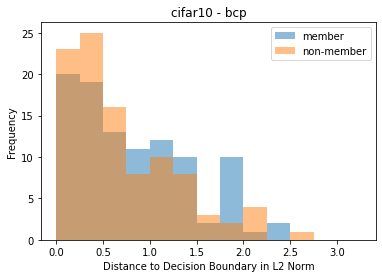

In [16]:
from matplotlib import pyplot as plt
import pandas as pd

def dist(x, x_adv):
    return np.linalg.norm(np.reshape(x_adv - x, [-1]))

dist_train = [dist(x, xa) for (x, xa) in zip(x_target_train[train_idx], x_adv_train)]
dist_test = [dist(x, xa) for (x, xa) in zip(x_target_test[test_idx], x_adv_test)]
print(pd.DataFrame(np.array(dist_train)).describe())
print(pd.DataFrame(np.array(dist_test)).describe())

bins = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25]

plt.hist(dist_train, bins, alpha=0.5, label='member')
plt.hist(dist_test, bins, alpha=0.5, label='non-member')
plt.legend(loc='upper right')
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("Distance to Decision Boundary in L2 Norm")
plt.ylabel("Frequency")
plt.show()

### 6. Measure the Advantage of An Adversary in Label-Only Membership Inference Attacks

[0.   0.01 0.01 0.04 0.04 0.05 0.05 0.06 0.06 0.07 0.07 0.09 0.09 0.1
 0.1  0.11 0.11 0.12 0.12 0.13 0.13 0.16 0.16 0.18 0.18 0.19 0.19 0.22
 0.22 0.23 0.23 0.25 0.25 0.26 0.26 0.27 0.27 0.28 0.28 0.31 0.31 0.32
 0.32 0.34 0.34 0.35 0.35 0.36 0.36 0.37 0.37 0.38 0.38 0.4  0.4  0.41
 0.41 0.46 0.46 0.51 0.51 0.52 0.52 0.55 0.55 0.57 0.57 0.62 0.62 0.65
 0.65 0.68 0.68 0.73 0.73 0.74 0.74 0.77 0.77 0.79 0.79 0.8  0.8  0.85
 0.85 0.92 0.92 0.93 0.93 0.94 0.94 0.95 0.95 0.96 0.96 0.98 0.98 1.  ]
[0.   0.   0.02 0.02 0.03 0.03 0.07 0.07 0.09 0.09 0.13 0.13 0.14 0.14
 0.15 0.15 0.17 0.17 0.18 0.18 0.23 0.23 0.25 0.25 0.27 0.27 0.28 0.28
 0.29 0.29 0.31 0.31 0.32 0.32 0.33 0.33 0.36 0.36 0.37 0.37 0.4  0.4
 0.44 0.44 0.45 0.45 0.46 0.46 0.49 0.49 0.5  0.5  0.53 0.53 0.54 0.54
 0.55 0.55 0.56 0.56 0.59 0.59 0.64 0.64 0.66 0.66 0.67 0.67 0.75 0.75
 0.77 0.77 0.78 0.78 0.79 0.79 0.8  0.8  0.83 0.83 0.85 0.85 0.86 0.86
 0.87 0.87 0.89 0.89 0.9  0.9  0.92 0.92 0.95 0.95 0.99 0.99 1.   1.  ]
[3.713

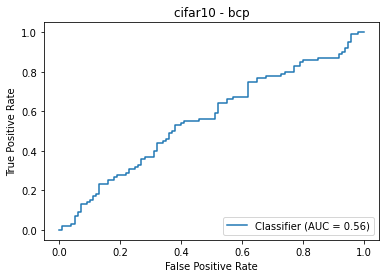

In [17]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, thresholds = roc_curve(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
print(fpr)
print(tpr)
print(thresholds)

RocCurveDisplay.from_predictions(
    np.concatenate((np.ones(len(dist_train)), np.zeros(len(dist_test)))),
    dist_train + dist_test
)
plt.title(f'{dataset} - {algorithm}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### 7. Measure the Statistical Relationship between Distance to Decision Boundary and Confidence Scores

In [15]:
from scipy.stats.stats import pearsonr
import scipy

confidence_train = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_train[train_idx])]
confidence_test = [np.amax(scipy.special.softmax(p)) for p in art_classifier.predict(x_target_test[test_idx])]

corr, pvalue = pearsonr(confidence_train, dist_train)
print("train correlation ", corr, pvalue)
corr, pvalue = pearsonr(confidence_test, dist_test)
print("test correlation ", corr, pvalue)

train correlation  0.8168004890744576 3.804592725521937e-25
test correlation  0.8244315454314872 5.756649744453923e-26
